<!-- # Bayesian sampler: Exploratory Data Analysis -->

It's time to look at the data rather than just fitting models like a maniac

In [72]:
%config IPCompleter.use_jedi = False
import numpyro
# numpyro.util.set_host_device_count(4)
# import numpyro.distributions as dist
# from numpyro.infer import MCMC, NUTS, Predictive

# from jax import numpy as jnp
# from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

from dfply import *

%run -i 'model_helpers.py'

In [73]:
df1 = load_query_avg_data_exp1() # see data_helpers.py
df1.head()

,ID,condition,querytype,querydetail,estimate
0,0,0,A,icy,0.503333
1,0,0,A,normal,0.500000
2,0,0,AandB,icy and frosty,0.616667
3,0,0,AandB,normal and typical,0.570000
4,0,0,AandnotB,icy and not frosty,0.453333


## plots I want

* Histograms of each trial response x condition
* Plots to explore conjunction/disjunction fallacies 
* For both participant means and at the trial level (x3 blocks/P)

# Experiment 1

To me the events used in Exp 1 are quite bizarre. If I were a participant I don't really know how I would answers questions like this. For instance, "icy or not frosty" basically seems like "A or ~A", so I would assign a probability of nearly 1. But few people are doing that, which to me suggests they are confused. I actually do see the sort of "pragmatic" reasoning suggested as plausible, as in "icy or not frosty" is to distinguish pure ice from frost. That's clearly different from icy or not frosty, which is nearly 100% guaranteed.

The case of "normal or not typical" is even weirder. If I were a psych review reviewer I would have told them to run another study with dependent events that aren't nearly identical. "cloudy and rainy" or "freezing and snowing" or whatever.

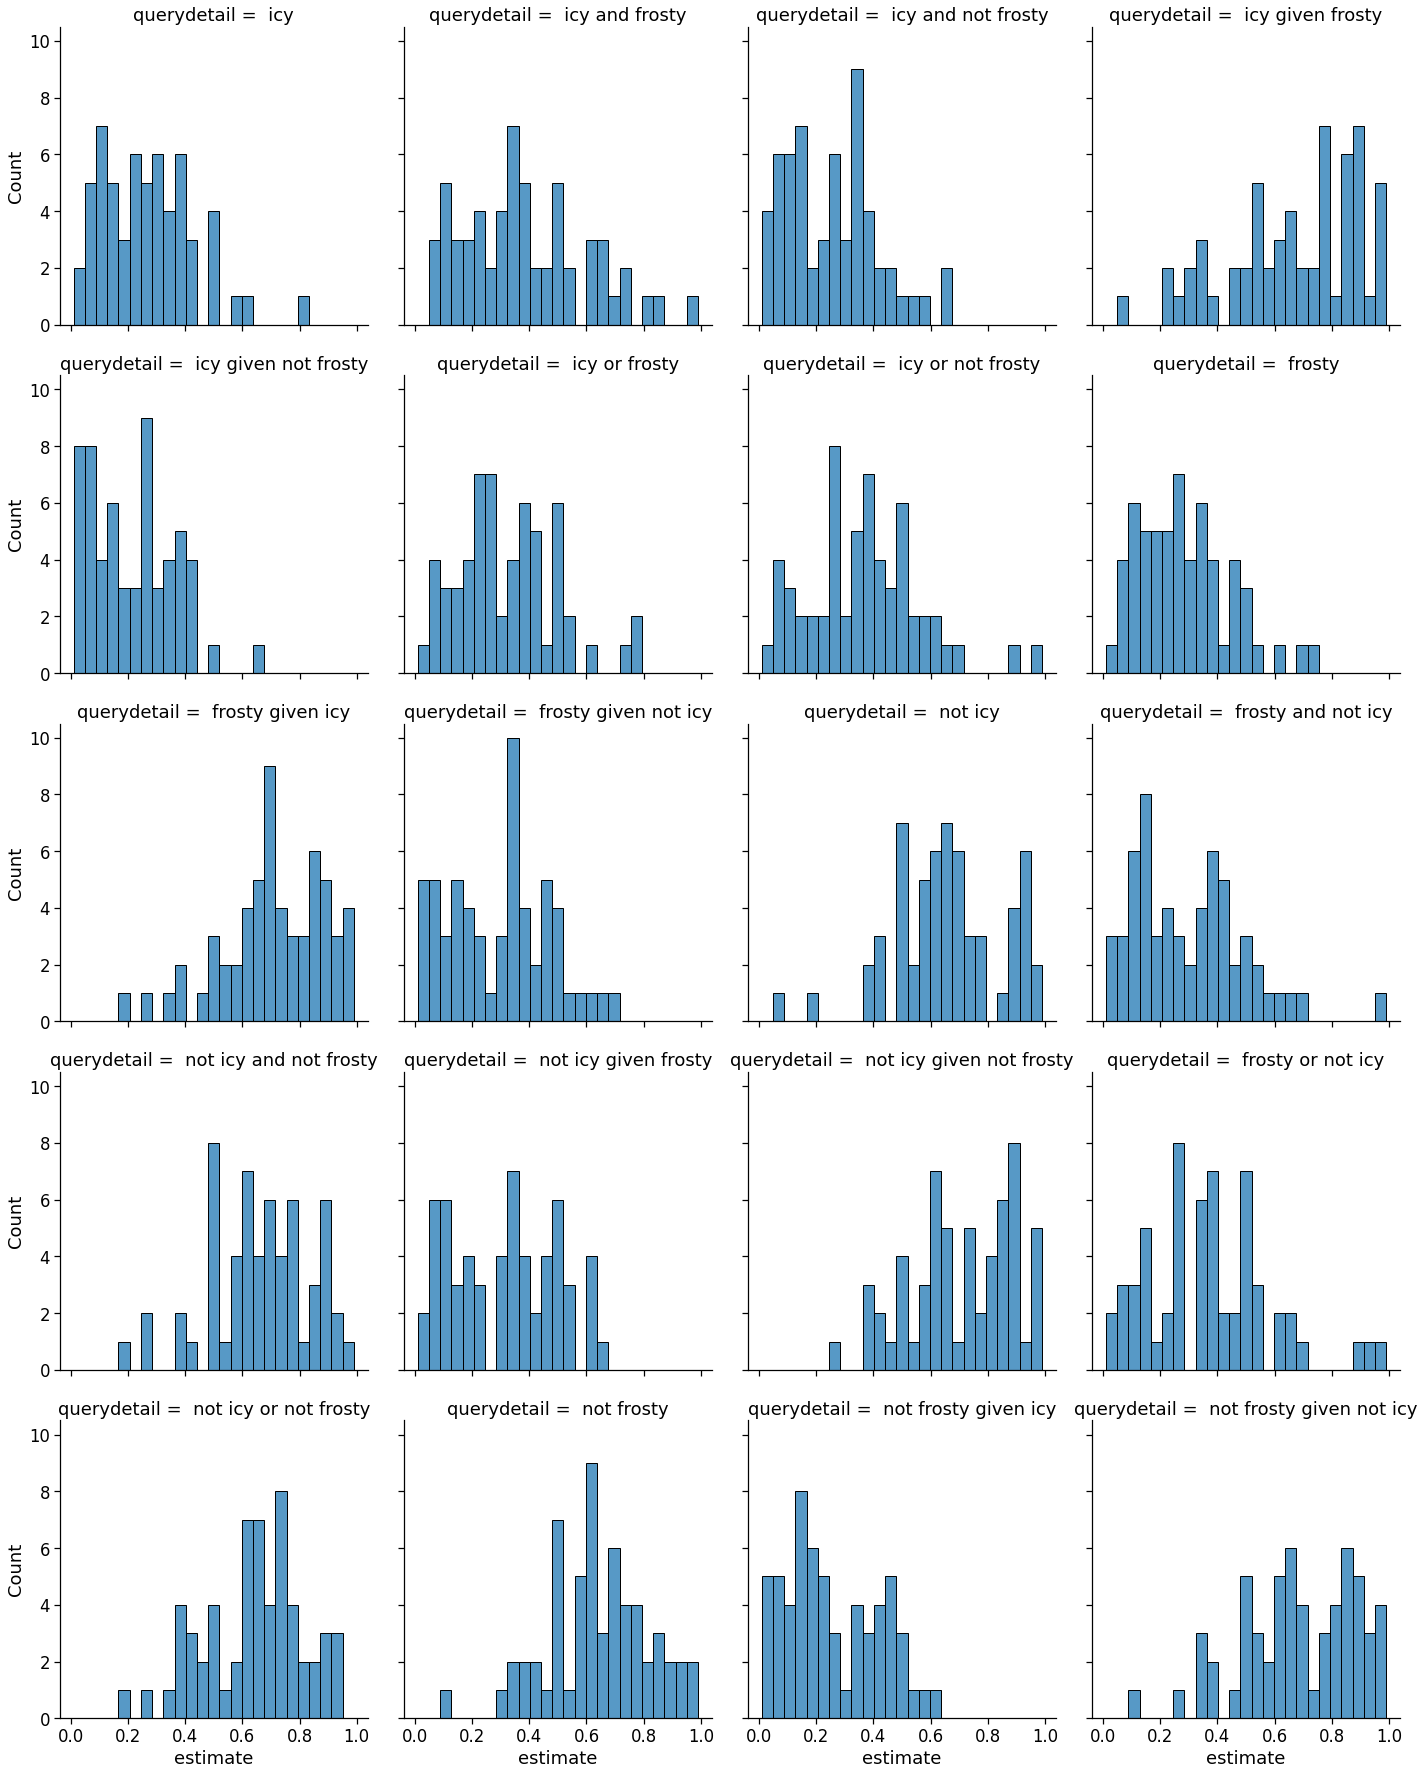

In [39]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.displot(df1[df1.querydetail.str.contains("icy|frosty")], x="estimate", col="querydetail", col_wrap=4, bins=25)

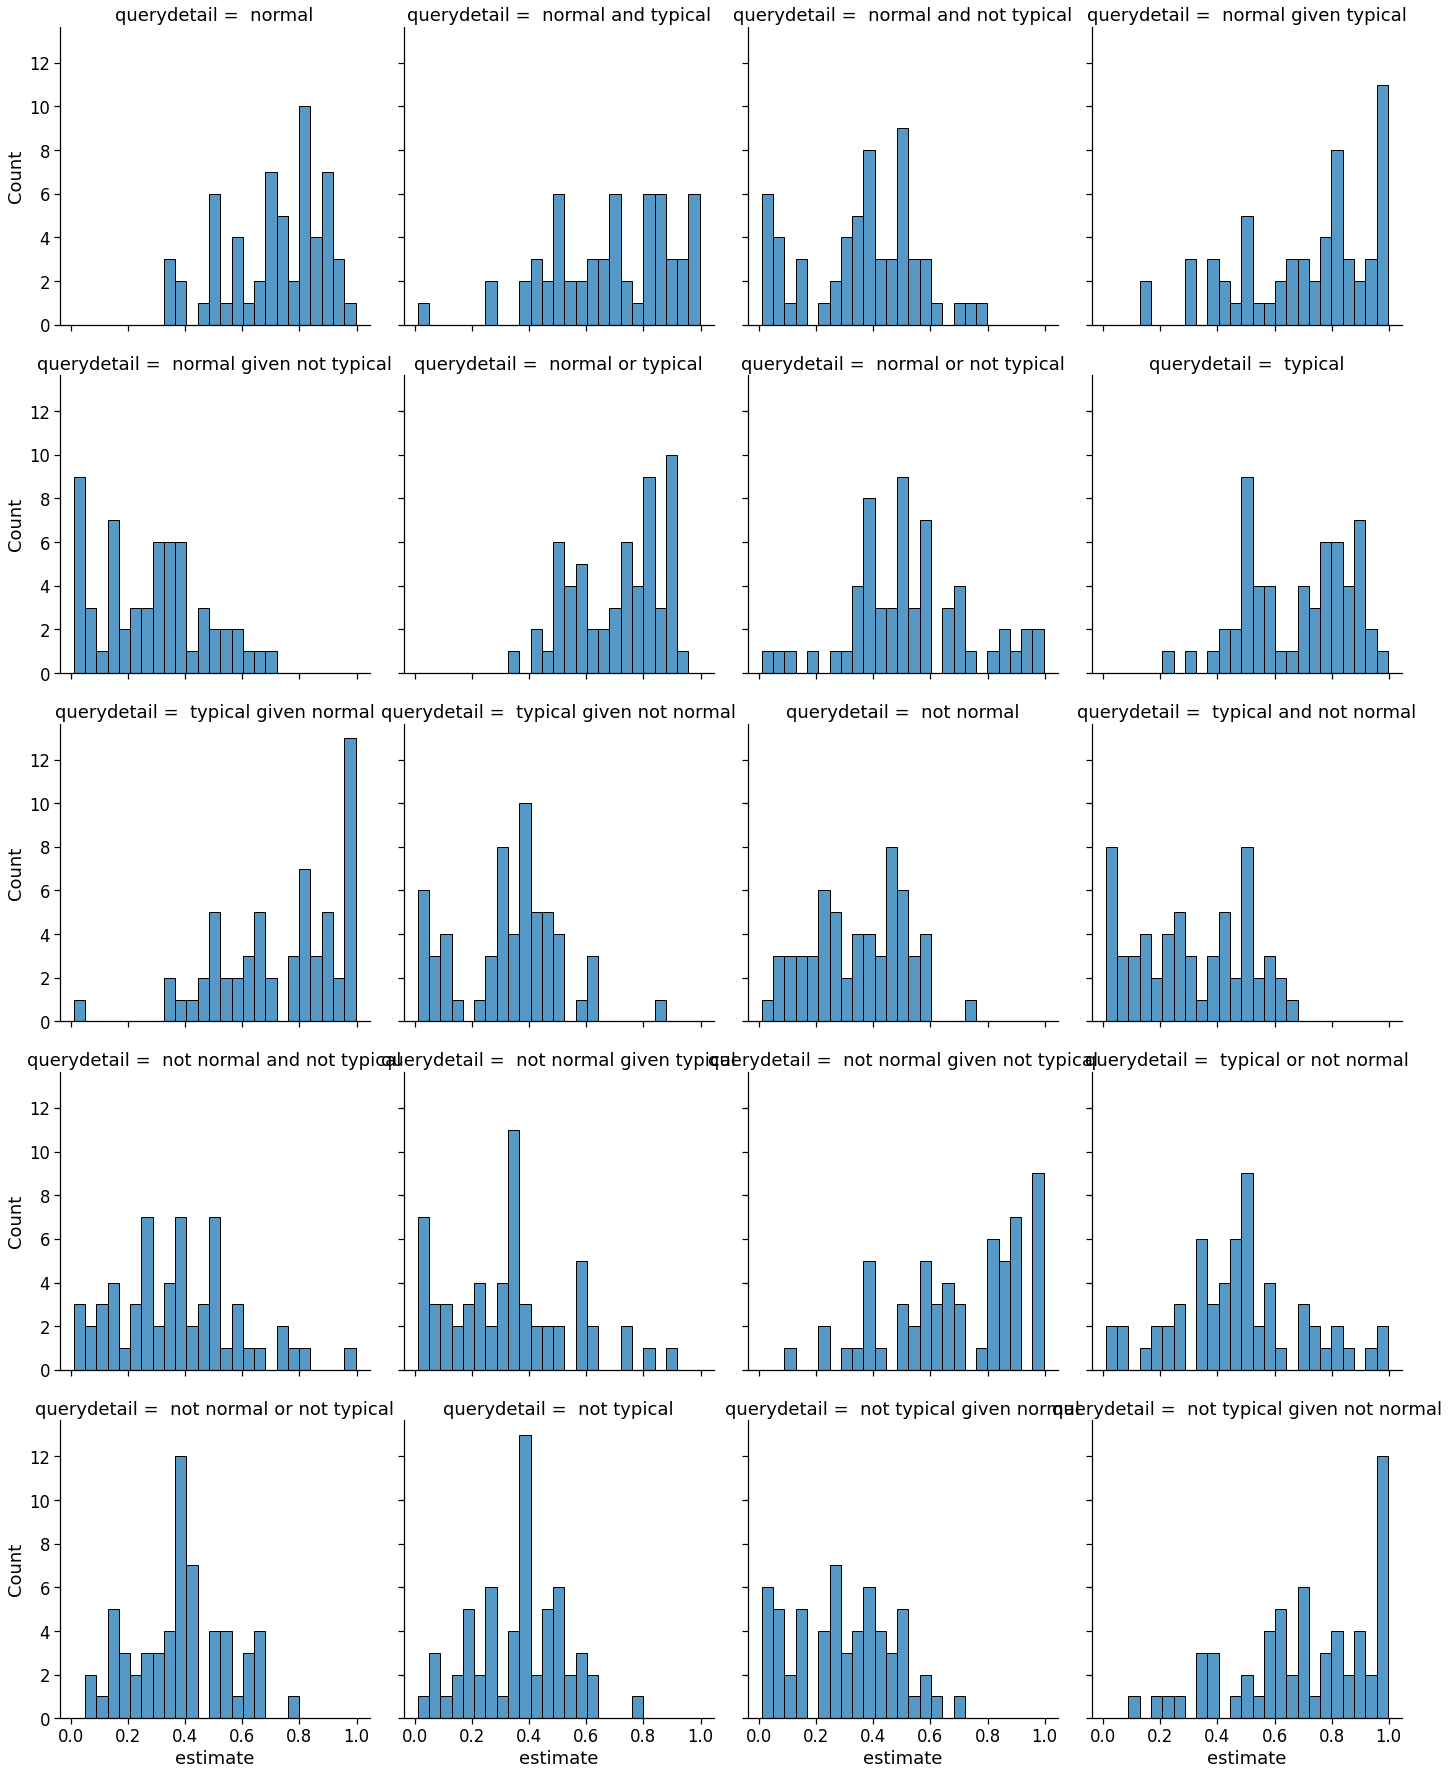

In [26]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.displot(df1[df1.querydetail.str.contains("normal|typical")], x="estimate", col="querydetail", col_wrap=4, bins=25)

# Experiment 2

It's strange that they excluded the "warmy, snowy" trials. I kind of suspect the reason is they may have done wonky things to their model fitting. But, they are a much less pragmatically problematic pair than icy/frosty or normal/typical. 

However, I also think the authors are right there is a sort of different reasoning process Ps might use for some trials. They referred to this as "qualitative reasoning" and I didn't really understand the idea/objection until now. But you might reason differently about "snowy and warm" or "warm given that it's snowy" than you do about other combinations. It's more of a logical question than a question you would use statistical experience to answer. If it's warm then it can't be snowy, so probability = 0. Of course if you really sort of "sampled" you might realize there could be days when it was snowy in the early morning then warmed up, etc. But that would be pretty low probability. But it might depend on how you interpreted the questions and how much time they covered and so forth (e.g. "warm and snowy" at the same time is not possible, but "warm and snowy" within the same day is). The way their questions are actually worded __SHOULD__ be read as warm and snowy in the same day, so a bit surprising this problem cropped up but it's hard to anticipate what people will do.

So again I think they've chosen two events that are just too tightly (de)coupled.

I think we'll need a mixture model!

In [41]:
df2 = load_query_avg_data_exp2() # see data_helpers.py
df2.head()

,querydetail,querytype,condition,ID,estimate
0,warm,A,0,0,0.586667
1,warm and snowy,AandB,0,0,0.010000
2,warm and not snowy,AandnotB,0,0,0.626667
3,warm given snowy,AgB,0,0,0.010000
4,warm given not snowy,AgnotB,0,0,0.683333


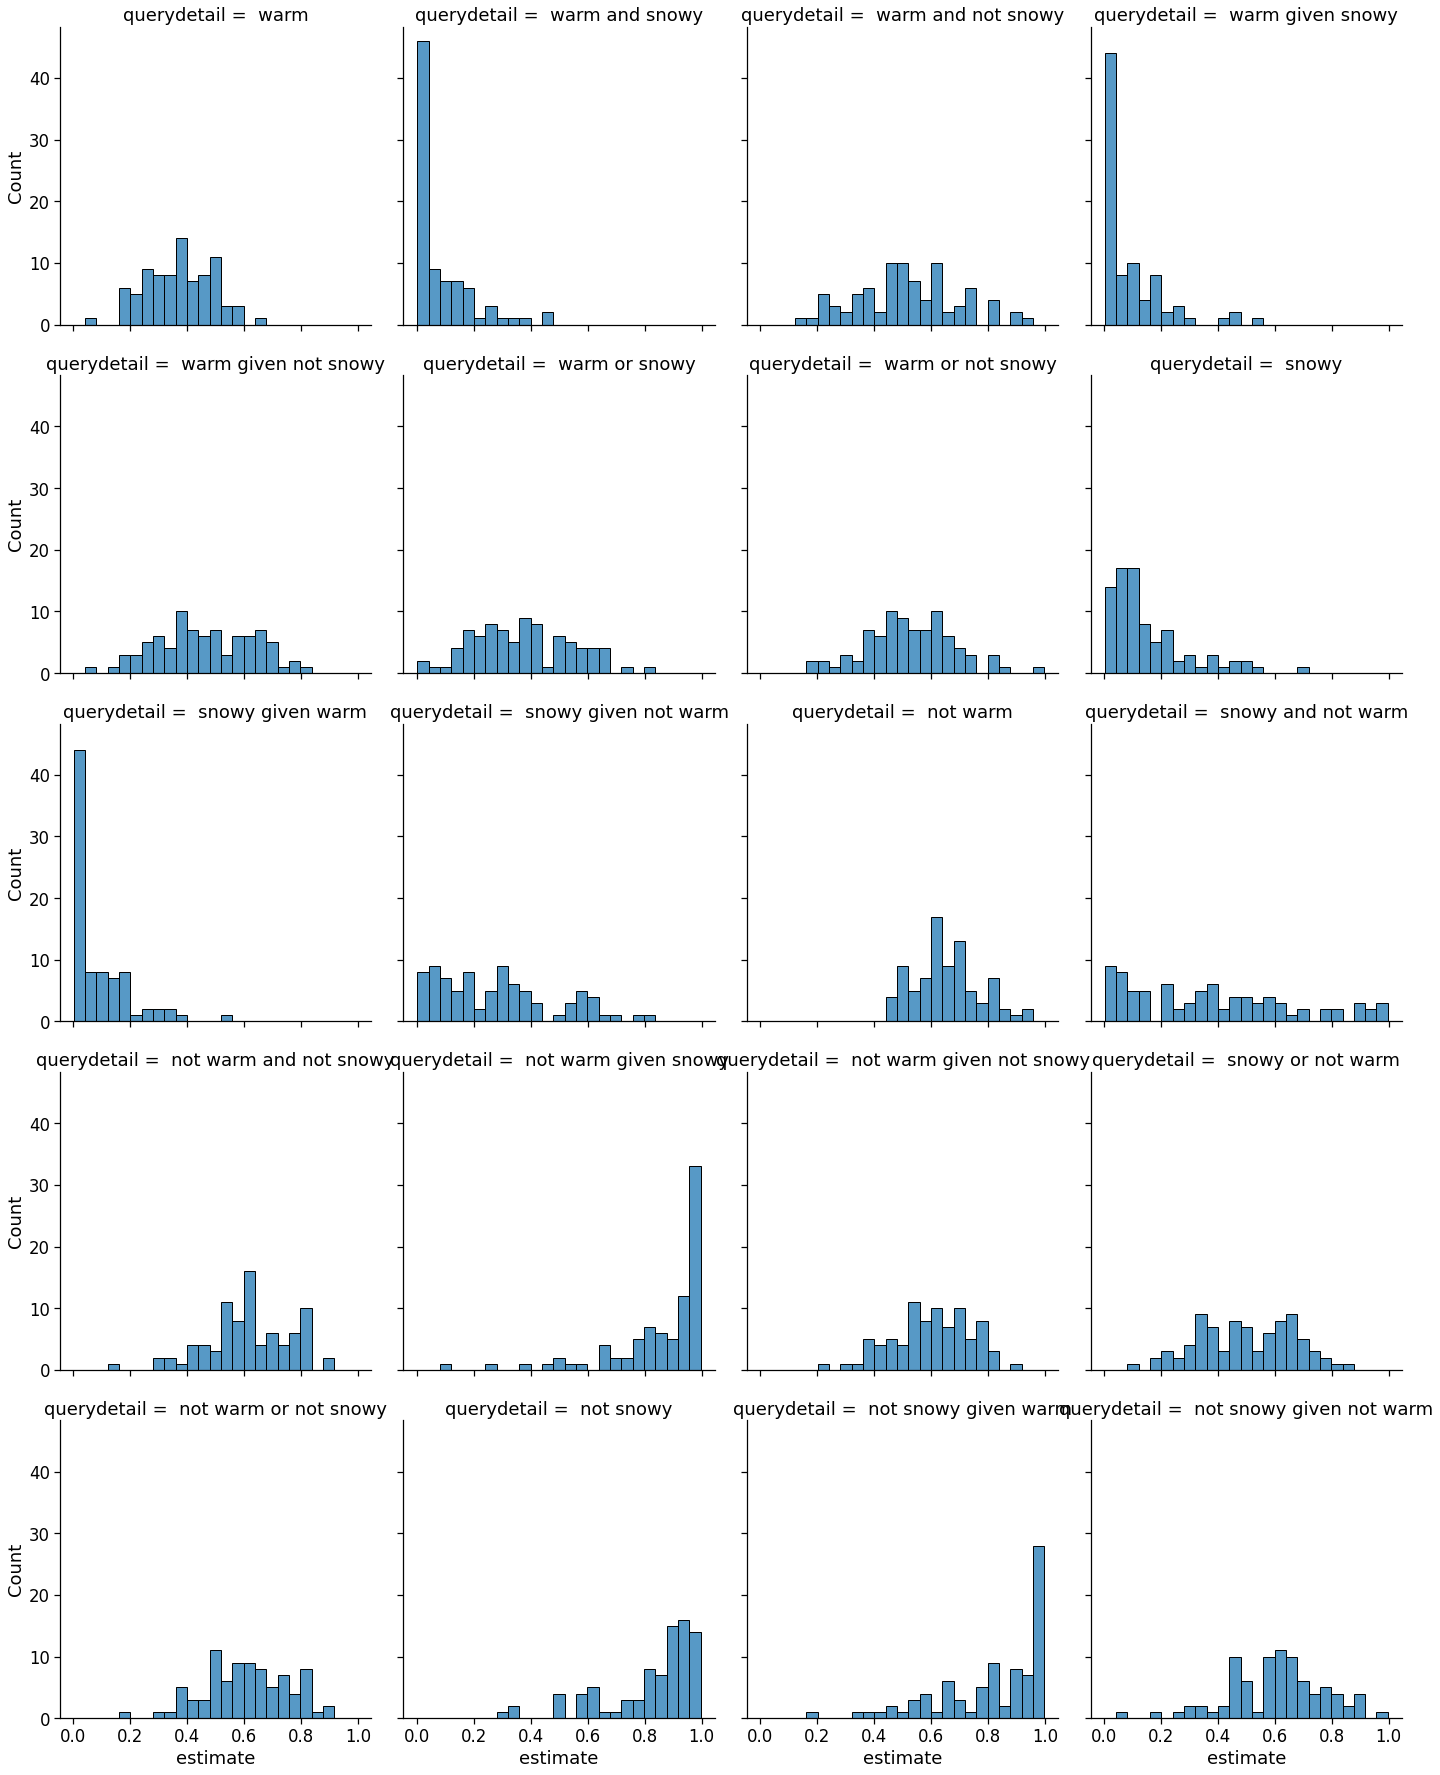

In [43]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.displot(df2[df2.condition==0], x="estimate", col="querydetail", col_wrap=4, bins=25)

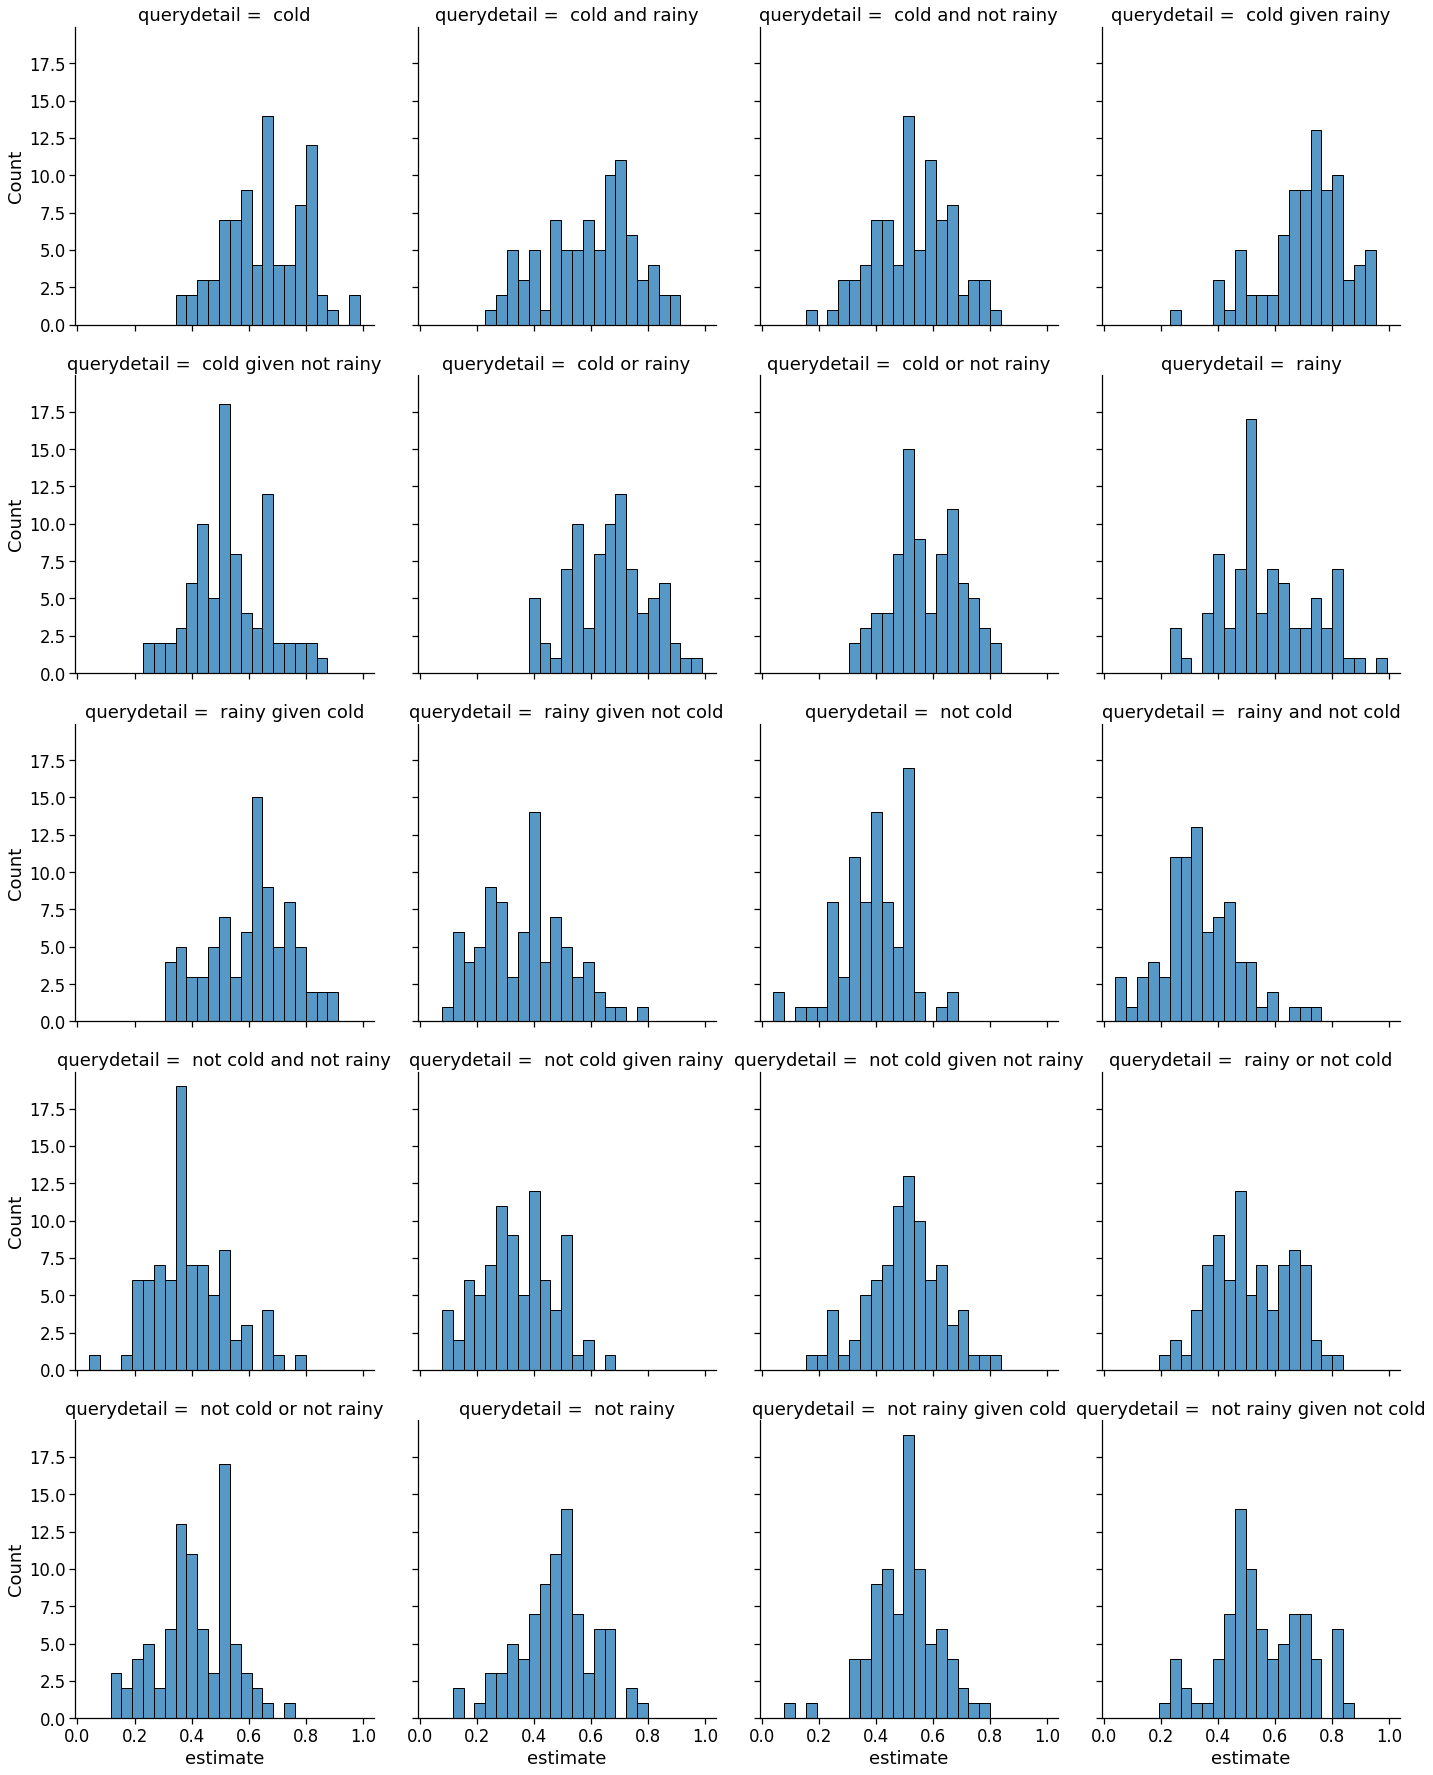

In [44]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.displot(df2[df2.condition==1], x="estimate", col="querydetail", col_wrap=4, bins=25)

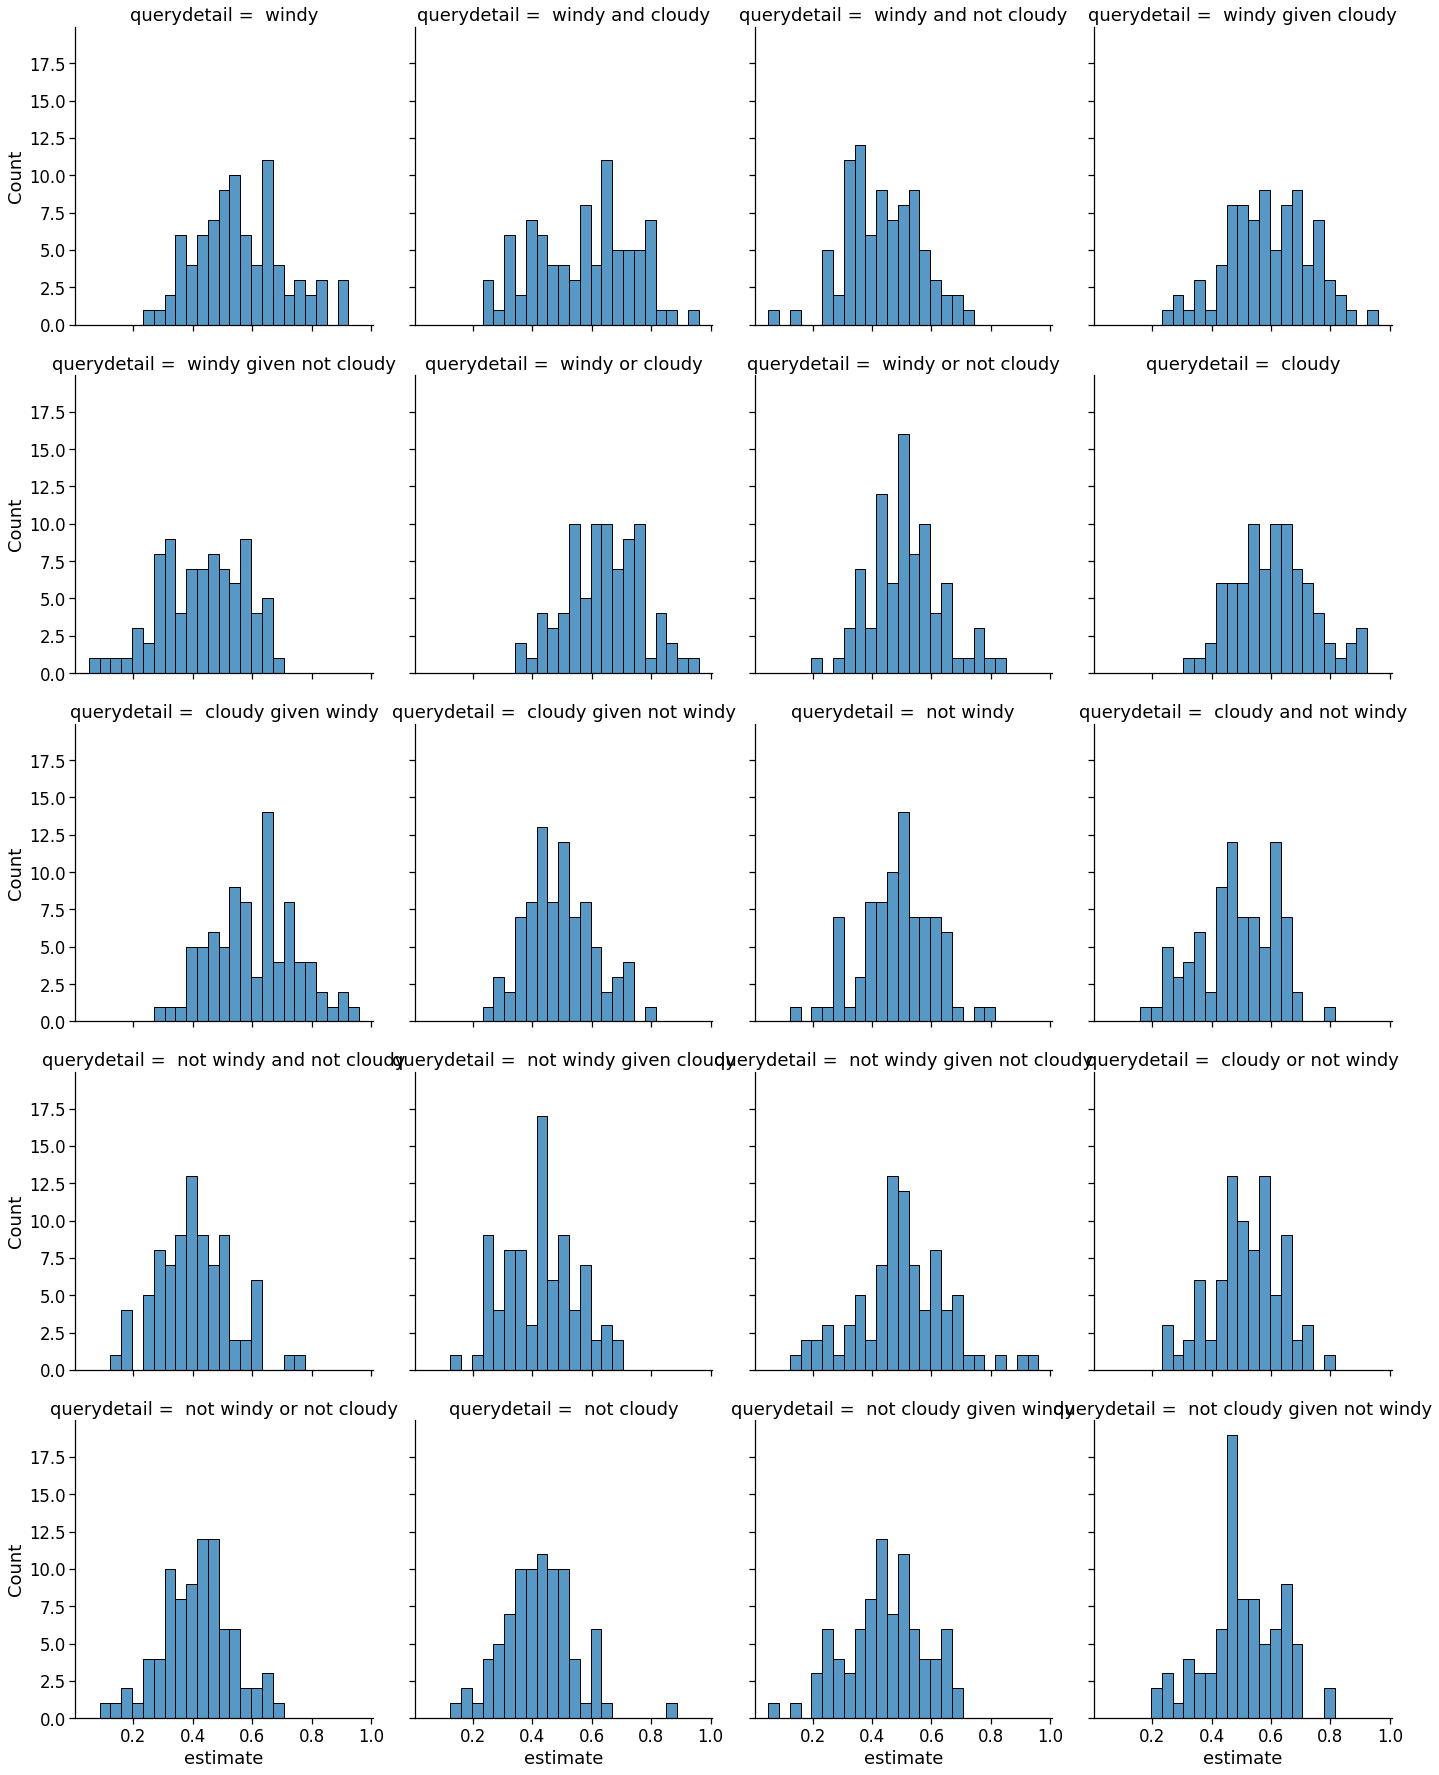

In [45]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.displot(df2[df2.condition==2], x="estimate", col="querydetail", col_wrap=4, bins=25)

In [55]:
df2_raw = load_data_exp2()
df2_raw = df2_raw.assign(remain_ten = df2_raw.estimate*100 % 10, remain_five = df2_raw.estimate*100 % 5)

<AxesSubplot:xlabel='remain_ten', ylabel='Count'>

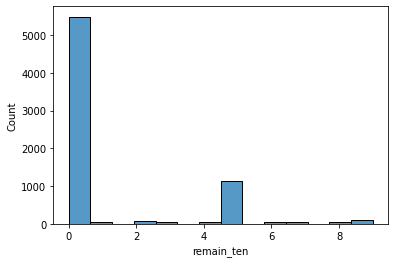

In [56]:
sns.histplot(x=df1_raw.remain_ten)

Nearly all responses are in tens, but about 1/5 trials are clearly rounded to five (or one; see spike at 5) and there are a few stray trials where they are definitely giving answers to the nearest ones place.

I could force rounding 

<AxesSubplot:ylabel='Count'>

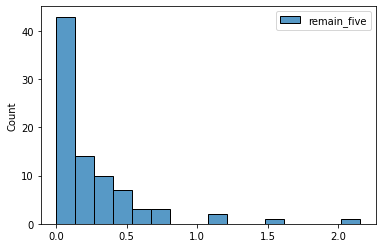

In [66]:
sns.histplot(df2_raw.assign(remainder = df2_raw.remain_ten * df2_raw.remain_five).groupby(["ID"]).agg({"remain_five":"mean"}))